# 0.0 Imports

In [1]:
from sqlalchemy          import create_engine
from sqlalchemy_utils    import database_exists, create_database
from postgre_credentials import *

import random
import xgboost    as xgb
import pandas            as pd
import psycopg2 as pg
import pandas.io.sql as psql
import numpy             as np
import seaborn           as sns
import scikitplot        as skplt
import matplotlib.pyplot as plt
import pickle
import sweetviz          as sv

from tabulate                 import tabulate
from IPython.core.display     import HTML
from IPython.display          import Image
from tqdm.notebook            import tqdm

from matplotlib import pyplot as plt

from sklearn import ensemble        as en
from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn import neighbors       as nh
from sklearn import linear_model    as lm

from scipy   import stats           as ss

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

# 0.1 Helper Functions

In [159]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 20
    display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
jupyter_settings()

def psycopg_connect():
    """"" Creates a psycopg connection from file postgre_credentials """""
    conn = pg.connect(    user = 'pg_user',
                          password = 'pg_pwd',
                          host = 'pg_host',
                          port = '5432', 
                          database = 'pg_Database')
    return conn

# precision at k is the proportion of recommended items in the top-k set that are relevant
# (# of our recommendations tha are relevant)/(# of items we recommended)
def precision_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()      
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

# Recall at k is the proportion of relevant items found in the top-k recommendations
# (# of our recommendations that are relevant)/ (# of all the possible relevant items)
def recall_at_k(data, x_val, y_val, yhat_model, k):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    
    # propensity score
    data['score'] = yhat_model[:, 1].tolist()  
    
    data = data.sort_values('score', ascending = False)
    
    # reset index
    data = data.reset_index(drop = True)

    # create ranking order
    #data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

# In classification tasks with imbalanced class distributions we should prefer stratifiedkfold over kfold, because the class distributions is preserved in the splits.
#def cross_validation(data, models_performance, num_folds, modelName, model, x_train, y_train, k):
def cross_validation(data, num_folds, modelName, model, x_train, y_train, k):
    
    kfold = ms.StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)
    
    precision_list = []
    recall_list = []
    #f1_score_list = []
    #roc_list = []
    
    i = 1
    for train_cv,val_cv in kfold.split(x_train, y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        
        precision = round(precision_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        precision_list.append(precision)
        
        recall = round(recall_at_k(data, x_val_fold, y_val_fold, yhat_model, k), 3)
        recall_list.append(recall)
        
    
    precision_str = np.round(np.mean(precision_list), 3).astype(str) + ' +/- ' + np.round(np.std(precision_list), 3).astype(str)
    recall_str    = np.round(np.mean(recall_list), 3).astype(str)    + ' +/- ' + np.round(np.std(recall_list), 3).astype(str)
    # there are others ranking metrics like F1-Score and Average precision but little used.
    
        
    #models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str], index = models_performance.columns), ignore_index = True)

    #return models_performance
    return {'Model Name': modelName, 'Precision_at_k': precision_str, 'Recall_at_k': recall_str}

# 0.2 Data Collection

In [4]:
HOST = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
PORT = '5432'
DATABASE = 'comunidadedsdb'
USER = 'member'
PASSWORD ='cdspa'

conn = pg.connect(host=HOST,
                  database=DATABASE,
                  port=PORT,
                  user=USER,
                  password=PASSWORD)

In [5]:
#select distinct schemas
query = "SELECT distinct(table_schema) from information_schema.tables"
df = pd.read_sql( query, conn )
df.head(10)

,table_schema
0,public
1,pg_catalog
2,information_schema
3,pa004


In [6]:
#select tables from schema
query = "SELECT * FROM information_schema.tables WHERE table_schema = 'pa004'"
df = pd.read_sql( query, conn )
df.head(10)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,comunidadedsdb,pa004,users,BASE TABLE,None,None,None,None,None,YES,NO,None
1,comunidadedsdb,pa004,vehicle,BASE TABLE,None,None,None,None,None,YES,NO,None
2,comunidadedsdb,pa004,insurance,BASE TABLE,None,None,None,None,None,YES,NO,None


In [7]:
query = """SELECT * FROM pa004.insurance """
df = pd.read_sql( query, conn )
df.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


In [8]:
query = """SELECT * FROM pa004.insurance """
df = pd.read_sql( query, conn )
df.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


In [9]:
#build raw dataset:
query = """
SELECT *
FROM pa004.users u 
INNER JOIN pa004.vehicle v on u.id = v.id 
INNER JOIN pa004.insurance i ON u.id = i.id
ORDER BY u.id
"""
df = pd.read_sql( query, conn )
df.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,1,> 2 Years,Yes,1,0,40454.0,217,1
1,2,Male,76,3.0,26.0,2,1,1-2 Year,No,2,0,33536.0,183,0
2,3,Male,47,28.0,26.0,3,1,> 2 Years,Yes,3,0,38294.0,27,1
3,4,Male,21,11.0,152.0,4,1,< 1 Year,No,4,1,28619.0,203,0
4,5,Female,29,41.0,152.0,5,1,< 1 Year,No,5,1,27496.0,39,0


# 1.0. Data Description

In [10]:
df1 = df.copy()

## 1.1 Remove duplicate columns (i.e. the 'id' from vehicle and insurance tables)

In [11]:
df1 = df1.loc[:,~df1.columns.duplicated()]
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   policy_sales_channel  381109 non-null  float64
 5   driving_license       381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   previously_insured    381109 non-null  int64  
 9   annual_premium        381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 1.2 Data Dimension

In [13]:
print(f'Number of rows: {df1.shape[0]} ')
print(f'Number of columns: {df1.shape[1]} ')

Number of rows: 381109 
Number of columns: 12 


## 1.3 Data Types

In [14]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

### Change data types

In [15]:
#convert df['region_code'] to int:
#df['region_code'].value_counts()
df1['region_code'] = df1['region_code'].astype(int)
df1['region_code'].head()

0    28
1     3
2    28
3    11
4    41
Name: region_code, dtype: int32

In [16]:
#convert df['policy_sales_channel'] to int:
#df['policy_sales_channel'].value_counts().head(50)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)
df1['policy_sales_channel'].head()

0     26
1     26
2     26
3    152
4    152
Name: policy_sales_channel, dtype: int32

In [17]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int32
policy_sales_channel      int32
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [18]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5 Rename Columns

In [19]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [20]:
df1 = df1.rename(columns={'previously_insured': 'vehicle_prev_insured',
                        'annual_premium': 'health_annual_paid',
                        'vintage': 'days_associated'})
df1

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28,26,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3,26,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28,26,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11,152,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41,152,1,< 1 Year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26,26,1,1-2 Year,No,1,30170.0,88,0
381105,381106,Male,30,37,152,1,< 1 Year,No,1,40016.0,131,0
381106,381107,Male,21,30,160,1,< 1 Year,No,1,35118.0,161,0
381107,381108,Female,68,14,124,1,> 2 Years,Yes,0,44617.0,74,0


## 1.6. Data Descriptive

In [21]:
#separate numerical attributes 
num_attributes = df1[['age','health_annual_paid','days_associated']]

#separate cathegorical attributes
cat_attributes = df1[['gender','region_code','policy_sales_channel','driving_license', 'vehicle_age', 'vehicle_damage', 'vehicle_prev_insured', 'response']]

In [22]:
num_attributes.sample(5)

,age,health_annual_paid,days_associated
229381,20,34387.0,257
155947,22,34952.0,251
227087,27,37261.0,57
112408,58,49316.0,132
160684,54,2630.0,17


In [23]:
# Numerical attributes 
#Central tendency metrics: mean and median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion metrics: standard deviation, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply ( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply ( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply ( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply ( lambda x: x.kurtosis() ) ).T

#Concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

In [24]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,health_annual_paid,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,days_associated,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


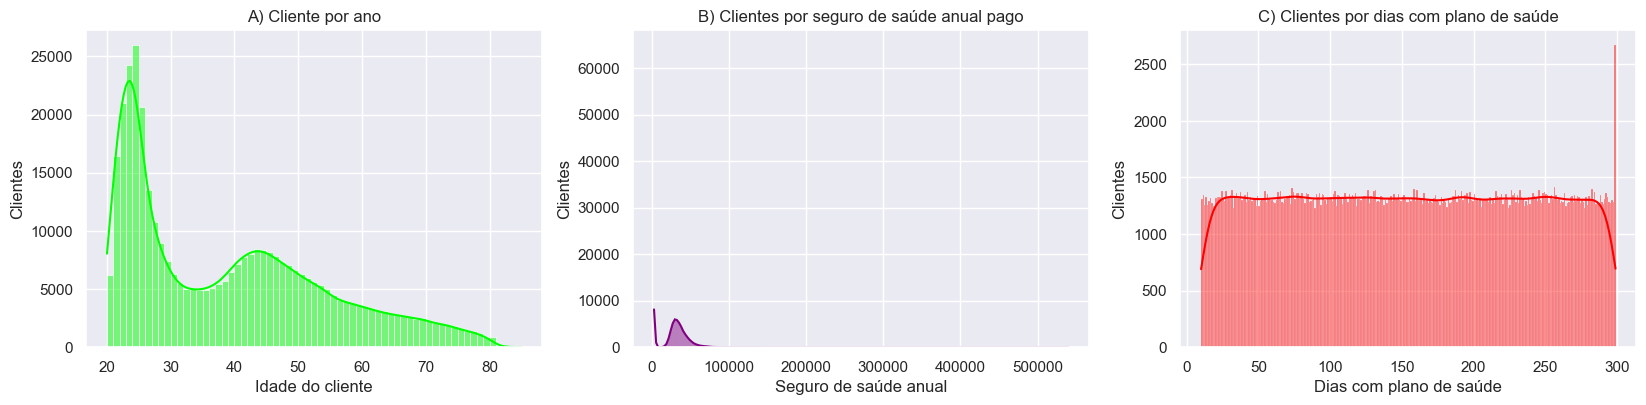

In [25]:
# Numerical attributes  plot
plt.figure(figsize=(20,14))

plt.subplot(3,3,1)
age_hist = sns.histplot(df1['age'], binwidth=1, kde=True, color="lime");
age_hist.set_ylabel('Clientes')
age_hist.set_xlabel('Idade do cliente')
age_hist.set_title('A) Cliente por ano');

plt.subplot(3,3,2)
hap_hist = sns.histplot(df1['health_annual_paid'], kde=True, color="purple");
hap_hist.set_ylabel('Clientes')
hap_hist.set_xlabel('Seguro de saúde anual')
hap_hist.set_title('B) Clientes por seguro de saúde anual pago');

plt.subplot(3,3,3)
da_hist = sns.histplot(df1['days_associated'], binwidth=1, kde=True, color="red");
da_hist.set_ylabel('Clientes')
da_hist.set_xlabel('Dias com plano de saúde')
da_hist.set_title('C) Clientes por dias com plano de saúde');

##### Os gráficos acima indicam que :
##### A) age                   - maioria dos clientes tem entre 20 e 30 anos
##### B) health_annual_premium - Kurtosi alta e muitos valores extremos
##### C) days_associated       - Uniforme, variável pode não ser tão últil

In [26]:
# cathegorical attributes
cat_attributes.sample(5)

,gender,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,response
170085,Female,33,26,1,1-2 Year,Yes,0,0
338447,Female,28,124,1,1-2 Year,Yes,0,0
89790,Male,29,124,1,1-2 Year,Yes,0,0
363045,Male,19,152,1,< 1 Year,No,1,0
202684,Female,32,160,1,< 1 Year,Yes,0,0


In [27]:
#Variações por coluna
print(f"- Valores diferentes:\n{cat_attributes.apply( lambda x: x.unique().shape[0] ) } \n" )
print(f"- Variações:\n{cat_attributes.apply( lambda x: x.unique() ) } " )

- Valores diferentes:
gender                    2
region_code              53
policy_sales_channel    155
driving_license           2
vehicle_age               3
vehicle_damage            2
vehicle_prev_insured      2
response                  2
dtype: int64 

- Variações:
gender                                                     [Male, Female]
region_code             [28, 3, 11, 41, 33, 6, 35, 50, 15, 45, 8, 36, ...
policy_sales_channel    [26, 152, 160, 124, 14, 13, 30, 156, 163, 157,...
driving_license                                                    [1, 0]
vehicle_age                               [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                                                  [Yes, No]
vehicle_prev_insured                                               [0, 1]
response                                                           [1, 0]
dtype: object 


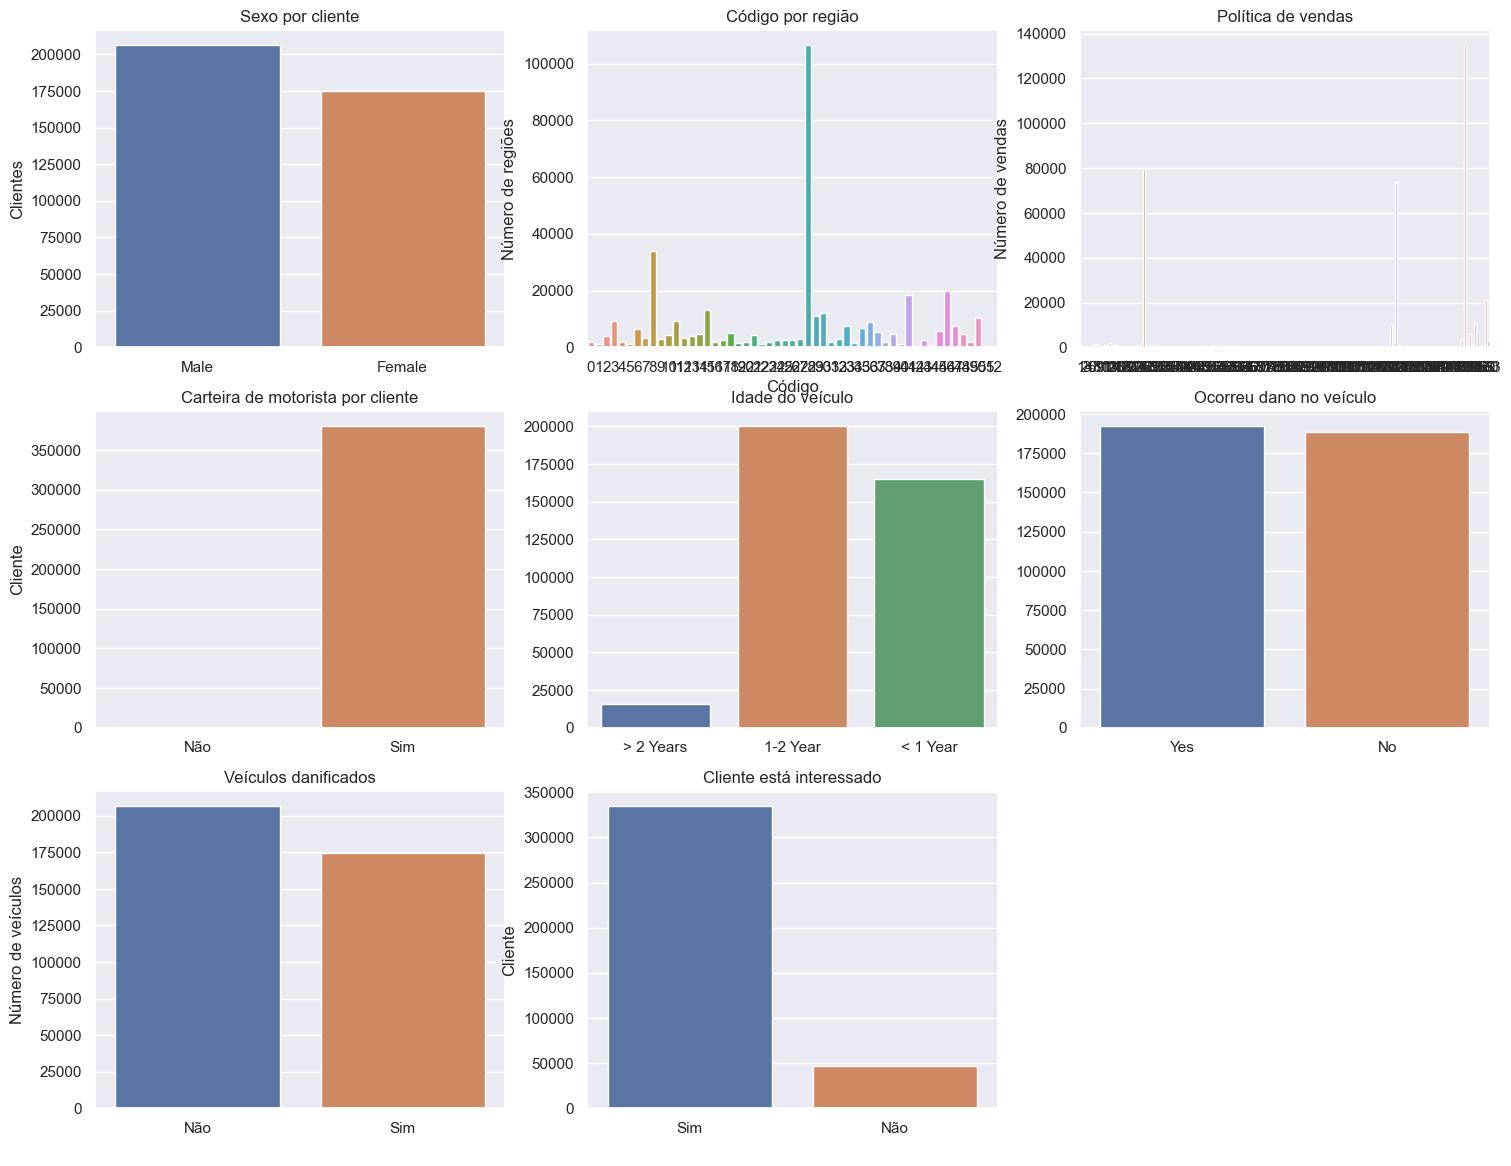

In [28]:
plt.figure(figsize=(18,14))

plt.subplot (3,3,1)
sns.countplot (x = cat_attributes['gender'])
plt.xlabel(' ')
plt.ylabel('Clientes')
plt.title('Sexo por cliente');

plt.subplot (3,3,2)
sns.countplot (x = cat_attributes['region_code'])
plt.xlabel('Código')
plt.ylabel('Número de regiões')
plt.title('Código por região');

plt.subplot (3,3,3)
sns.countplot (x = cat_attributes['policy_sales_channel'])
plt.xlabel(' ')
plt.ylabel('Número de vendas')
plt.title('Política de vendas');

plt.subplot (3,3,4)
sns.countplot (x = cat_attributes['driving_license'])
plt.xticks([0,1],['Não','Sim'])
plt.xlabel(' ')
plt.ylabel('Cliente')
plt.title('Carteira de motorista por cliente');

plt.subplot (3,3,5)
sns.countplot (x = cat_attributes['vehicle_age']);
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Idade do veículo');

plt.subplot (3,3,6)
sns.countplot (x = cat_attributes['vehicle_damage']);
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Ocorreu dano no veículo');

plt.subplot (3,3,7)
sns.countplot (x = cat_attributes['vehicle_prev_insured'])
plt.xticks([0,1],['Não','Sim'])
plt.xlabel(' ')
plt.ylabel('Número de veículos')
plt.title('Veículos danificados');

plt.subplot (3,3,8)
sns.countplot (x = cat_attributes['response']);
plt.xticks([0,1],['Sim','Não']);
plt.xlabel(' ')
plt.ylabel('Cliente')
plt.title('Cliente está interessado');

##### Os gráficos acima indicam que :


## 1.7 Columns Description

In [29]:
tab_meanings = [['Variável/Feature', 'Significado'],
        ['id', 'identificador único de cliente'],
        ['gender', 'Gênero do cliente: Male / Female.'],
        ['age', 'idade do cliente.'],
        ['region_code', 'código da região do cliente.'],
        ['policy_sales_channel', 'Código anônimo para o canal de divulgação ao cliente. Ie: Over Mail, Over Phone, In Person, etc..'],
        ['driving_license', '0 = cliente não tem, 1 = cliente tem'],
        ['vehicle_age', 'idade do veículo: < 1 Year, 1-2 Year, > 2 Years'],
        ['vehicle_damage', 'No = cliente nunca teve seu veículo danificado no passado, Yes = teve.'],
        ['vehicle_prev_insured', '0 = cliente não tem seguro do veículo, 1= já tem seguro do veículo.'],
        ['health_annual_premium', 'valor anual pago pelo cliente à empresa pelo seguro saúde. Moeda: Rs(Pakistani rupee, R$1.00 = ± Rs0.03).'],
        ['days_associated', 'número de dias desde que o cliente ingressou na empresa adquirindo um plano de saúde. A política é anual.'],
        ['response', '0 = cliente não está interessado, 1 = cliente está interessado.']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='rst'))

=====================  =========================================================================================================
Variável/Feature       Significado
=====================  =========================================================================================================
id                     identificador único de cliente
gender                 Gênero do cliente: Male / Female.
age                    idade do cliente.
region_code            código da região do cliente.
policy_sales_channel   Código anônimo para o canal de divulgação ao cliente. Ie: Over Mail, Over Phone, In Person, etc..
driving_license        0 = cliente não tem, 1 = cliente tem
vehicle_age            idade do veículo: < 1 Year, 1-2 Year, > 2 Years
vehicle_damage         No = cliente nunca teve seu veículo danificado no passado, Yes = teve.
vehicle_prev_insured   0 = cliente não tem seguro do veículo, 1= já tem seguro do veículo.
health_annual_premium  valor anual pago pelo cliente à empresa pel

# 2.0. Feature Engineering

In [30]:
df2 = df1.copy()

In [31]:
# Vehicle Damage Number
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

## 2.1 Mental Map Hyphotesis

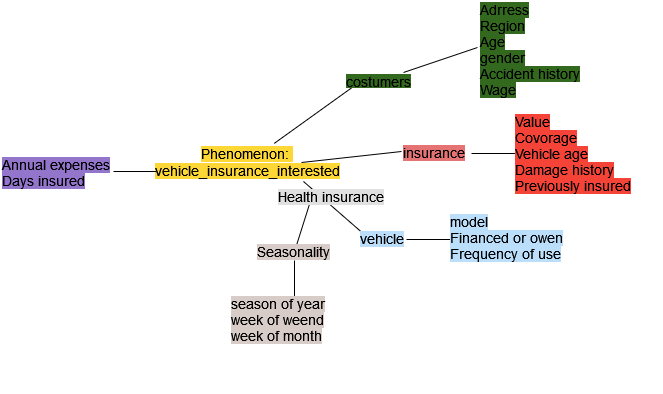

In [258]:
Image('figures/hyphotesis_map.png')

## 2.2 Hyphotesis Criation

### 2.2.1 Hipóteses do Cliente
**1.** Women are more likely to purchase car insurance.<br>
**2.** The greater the age, the greater the possibility of taking out auto insurance.<br>
**3.** Residence influences the decision to take out auto insurance.<br>
**4.** People who have had damage to their car are more likely to take out car insurance.<br>
**5.** Customers with higher health insurance expenses are more likely to purchase a new product.<br>

# 3.0. Data Filtering

In [32]:
df3 = df2.copy()

In [33]:
df3.to_csv('data/df_teste.csv', index=False)

# 4.0. Exploratoria Data Analysis

In [35]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Age

<AxesSubplot: xlabel='response', ylabel='age'>

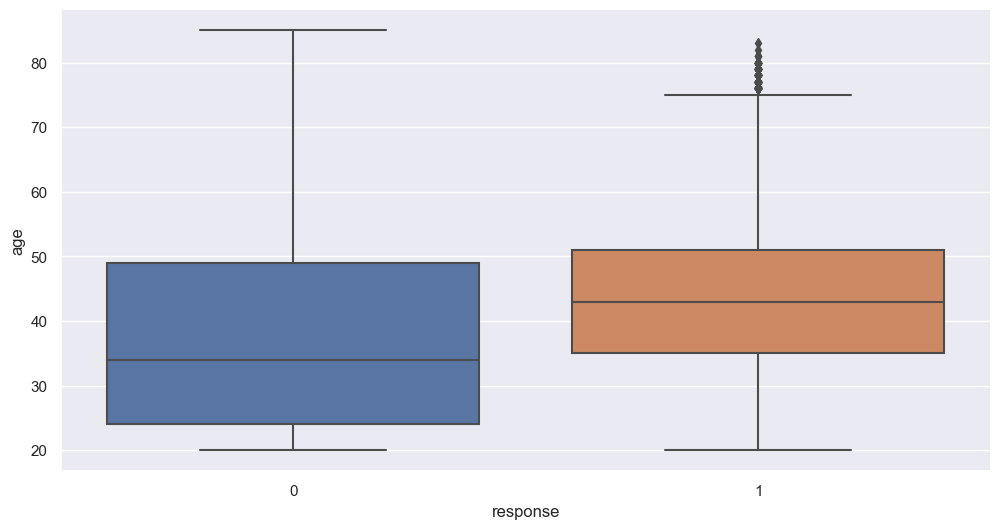

In [36]:
sns.boxplot( x='response', y='age', data=df4 )

<AxesSubplot: xlabel='age', ylabel='Count'>

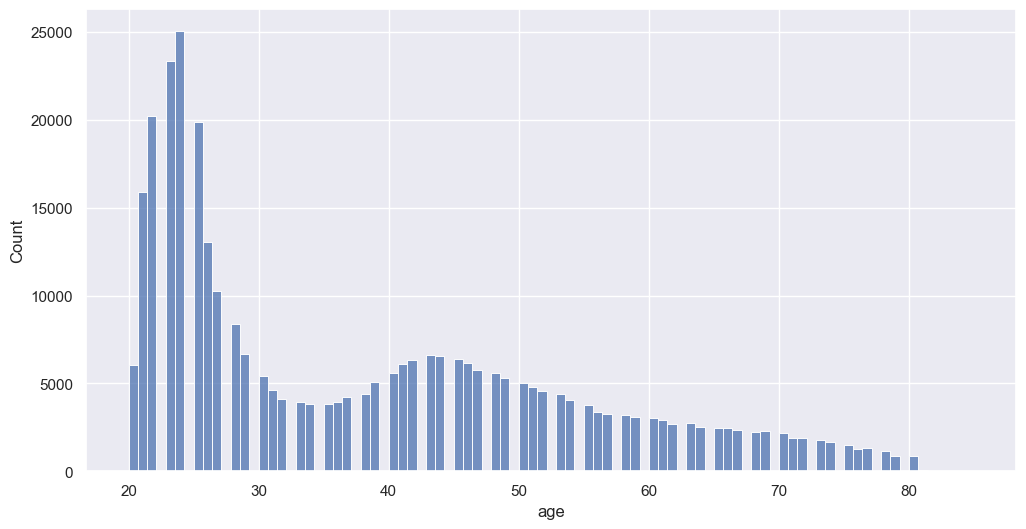

In [37]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

<AxesSubplot: xlabel='age', ylabel='Count'>

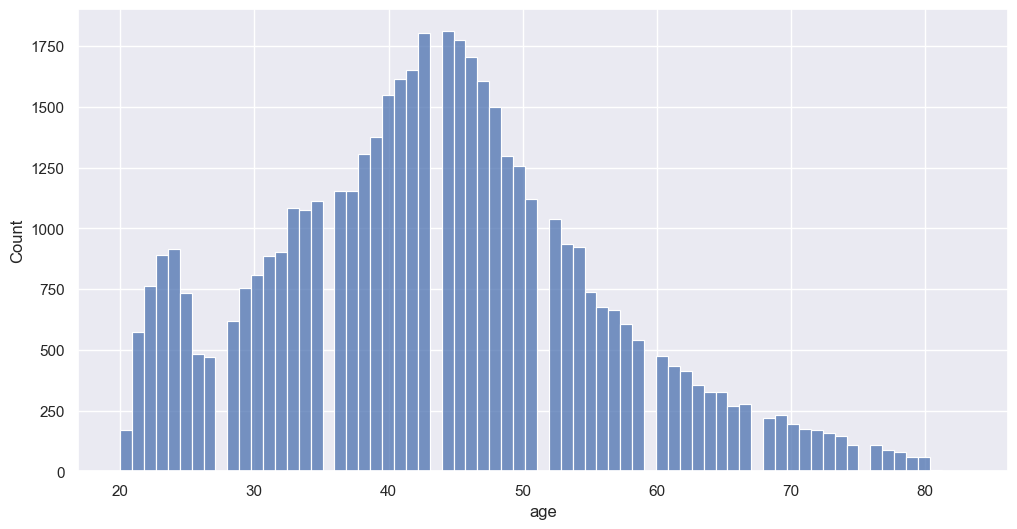

In [38]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 )

### 4.1.2. Anual Income

<AxesSubplot: xlabel='response', ylabel='health_annual_paid'>

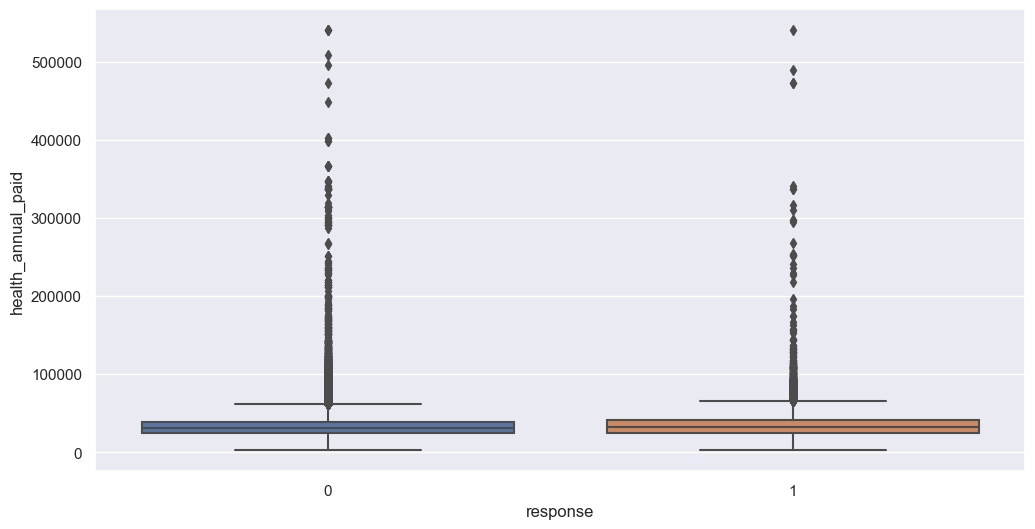

In [39]:
sns.boxplot( x='response', y='health_annual_paid', data=df4 )

In [40]:
df4 = df4[(df4['health_annual_paid'] > 10000) &(df4['health_annual_paid'] < 100000)]

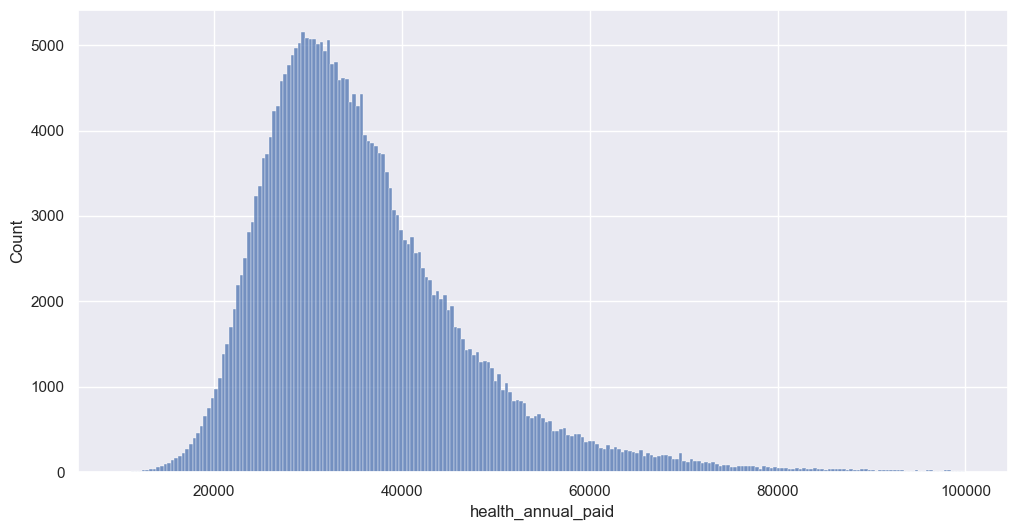

In [41]:
aux00 = df4.loc[df4['response'] == 0, 'health_annual_paid']
sns.histplot( aux00 );

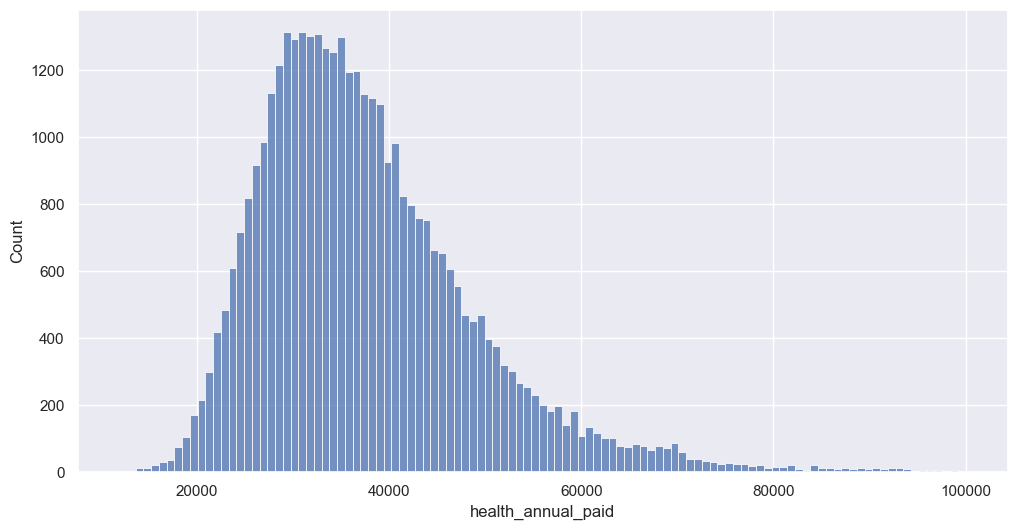

In [42]:
aux00 = df4.loc[df4['response'] == 1, 'health_annual_paid']
sns.histplot( aux00 );

### 4.1.3. Driving License

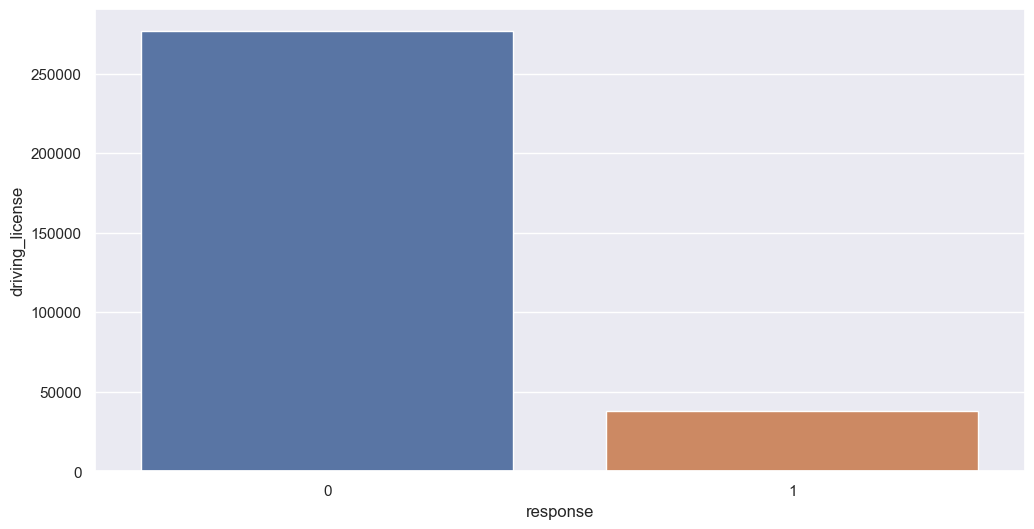

In [43]:
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='driving_license', data=aux );

### 4.1.4. Region Code

<AxesSubplot: xlabel='region_code', ylabel='id'>

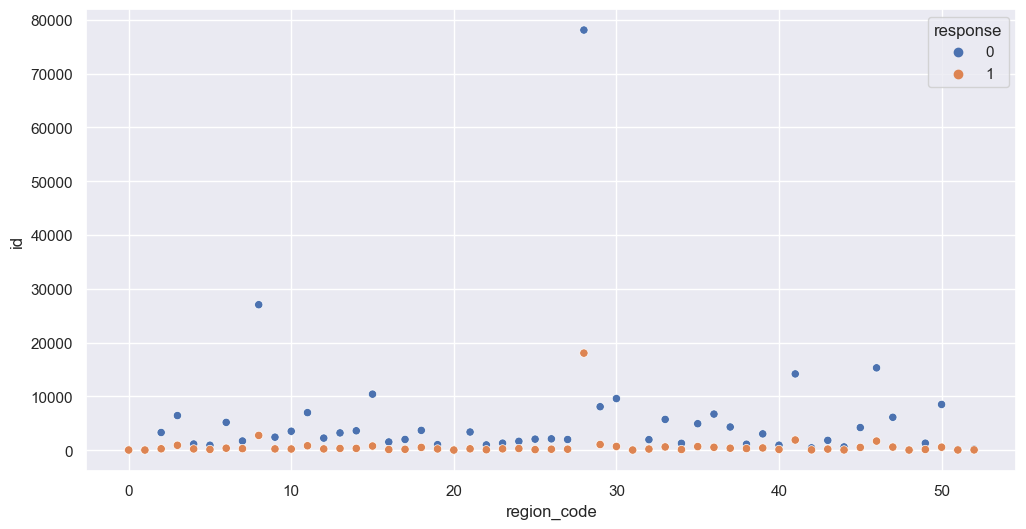

In [44]:
aux0 = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='region_code', y='id', hue='response', data=aux0 )

### 4.1.5. Previously Insured

<AxesSubplot: xlabel='vehicle_prev_insured', ylabel='id'>

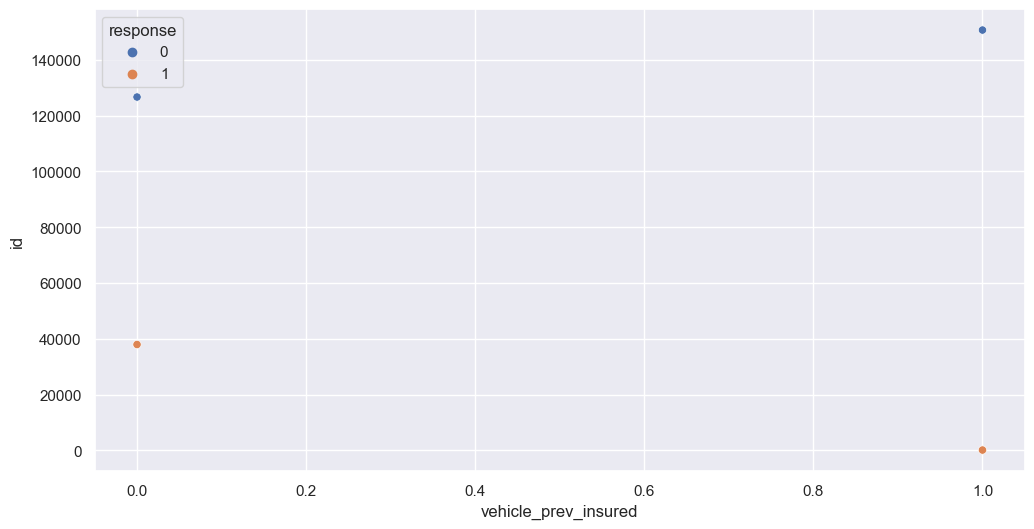

In [45]:
aux0 = df4[['id', 'vehicle_prev_insured', 'response']].groupby( ['vehicle_prev_insured', 'response'] ).count().reset_index()
#aux0 = aux0[(aux0['id'] > 1000) & (aux0['id'] < 20000)]

sns.scatterplot( x='vehicle_prev_insured', y='id', hue='response', data=aux0 )

In [46]:
pd.crosstab(df4['vehicle_prev_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1 )

response,0,1
vehicle_prev_insured,,
0,0.769438,0.230562
1,0.999191,0.000809


### 4.1.6. Vehicle Age

In [47]:
df4[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index()

,vehicle_age,response,id
0,below_1_year,0,137861
1,below_1_year,1,5994
2,between_1_2_year,0,130381
3,between_1_2_year,1,28017
4,over_2_years,0,9126
5,over_2_years,1,4070


### 4.1.7. Vehicle Damage

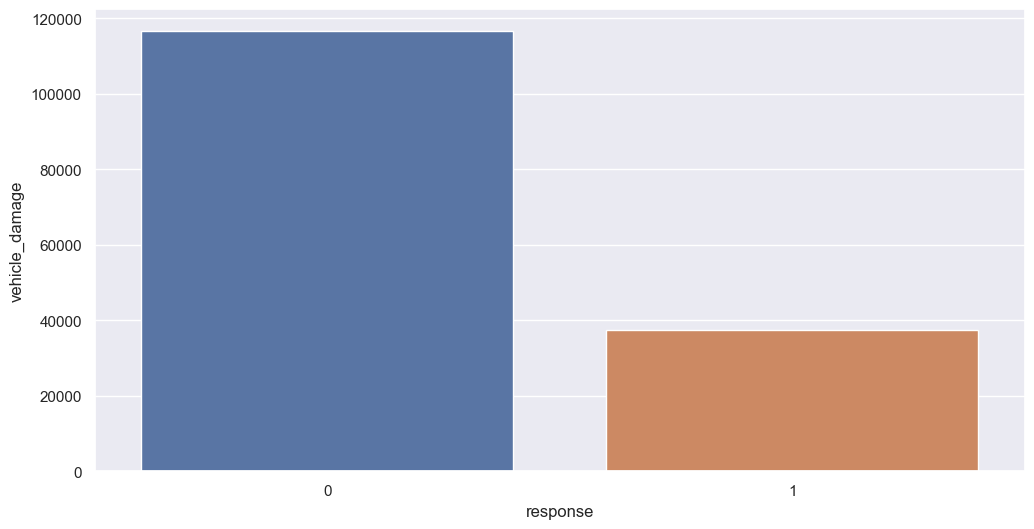

In [48]:
aux = df4[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

### 4.1.8. Policy Sales Channel - Stacked Percentage Bar

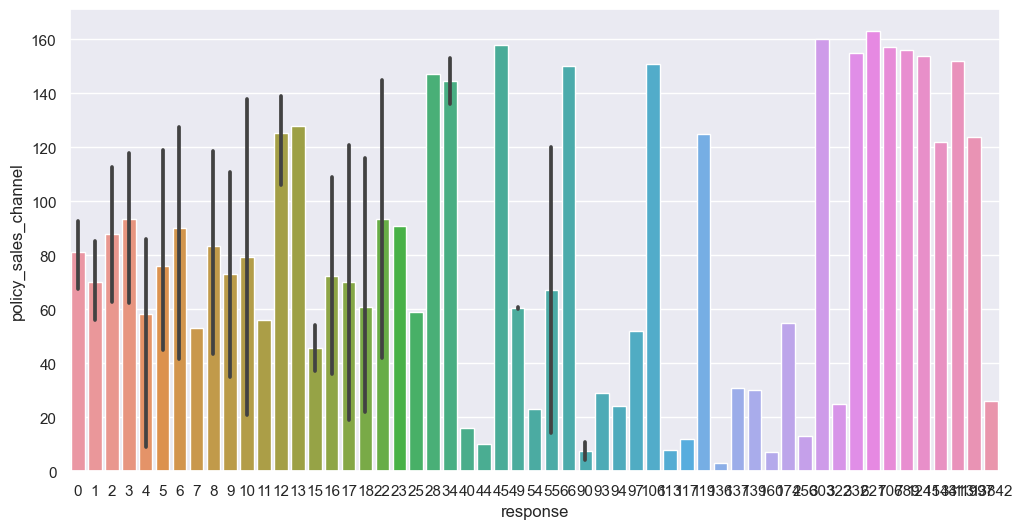

In [49]:
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );

In [50]:
aux01 = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).sum().reset_index()
aux02 = df4[['id', 'policy_sales_channel']].groupby( 'policy_sales_channel' ).size().reset_index().rename( columns={0:'total_responses'})

aux = pd.merge( aux01, aux02, how='inner', on='policy_sales_channel' )
aux.head()

,policy_sales_channel,response,total_responses
0,1,0,10
1,2,0,1
2,3,136,434
3,4,90,442
4,6,0,2


### 4.1.9. Vintage

<AxesSubplot: xlabel='days_associated', ylabel='Count'>

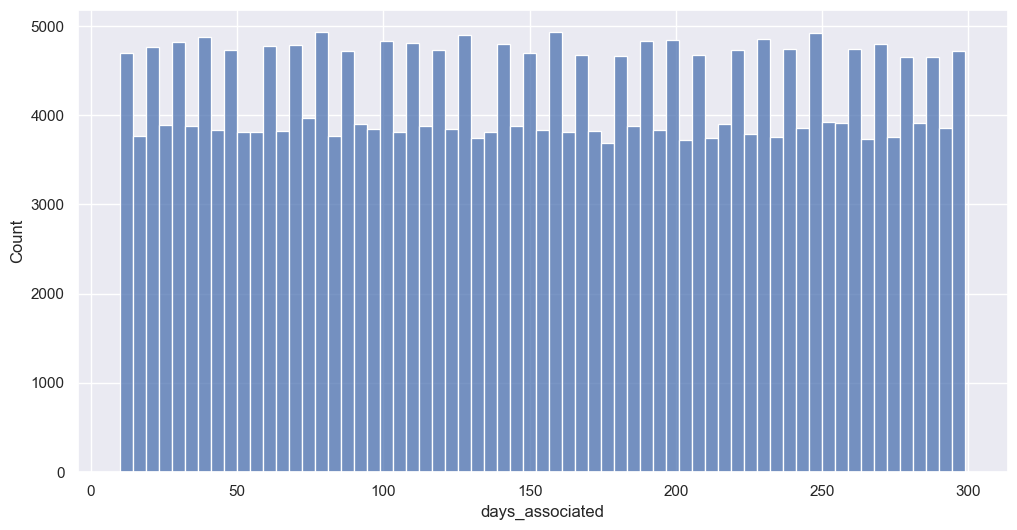

In [51]:
aux = df4.loc[df4['response'] == 0, 'days_associated']
sns.histplot( aux )

<AxesSubplot: xlabel='days_associated', ylabel='Count'>

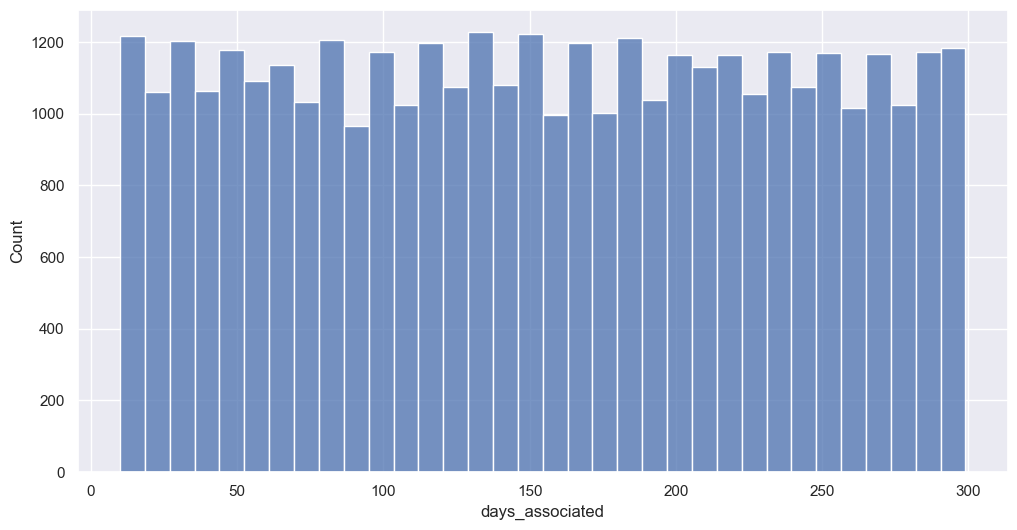

In [52]:
aux = df4.loc[df4['response'] == 1, 'days_associated']
sns.histplot( aux )

In [53]:
df = pd.pivot_table( index='days_associated', columns='response', values='id', data=df4).reset_index()
df.columns = ['days_associated', 'no_response', 'yes_response']

<AxesSubplot: xlabel='days_associated'>

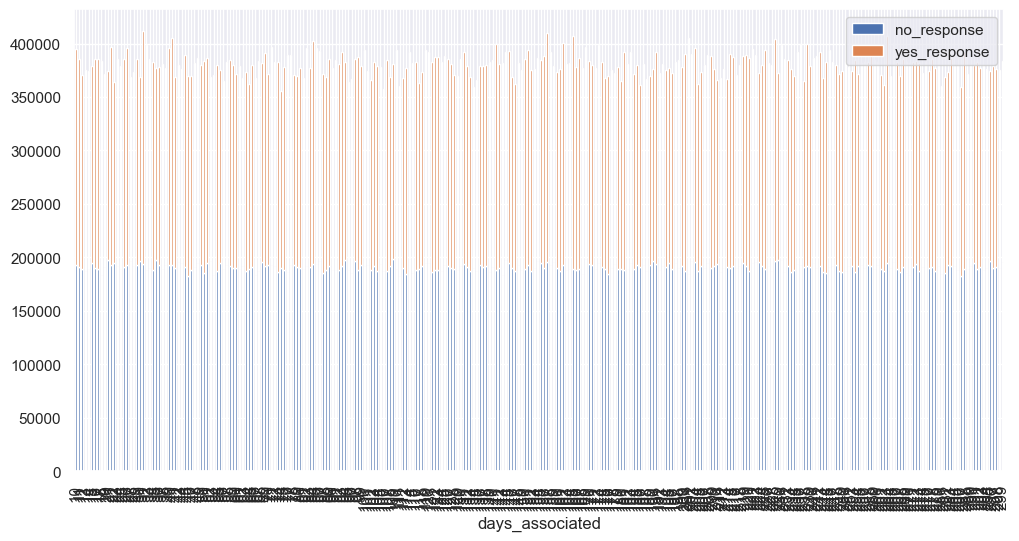

In [54]:
df.plot( x='days_associated', kind='bar', stacked=True)

## 4.2 Bivariate Analysis

### 4.2.1 Hyphotesis Validation

#### H1: Women are more likely to purchase car insurance.

##### The hypothesis is FALSE, the interest among men is greater.

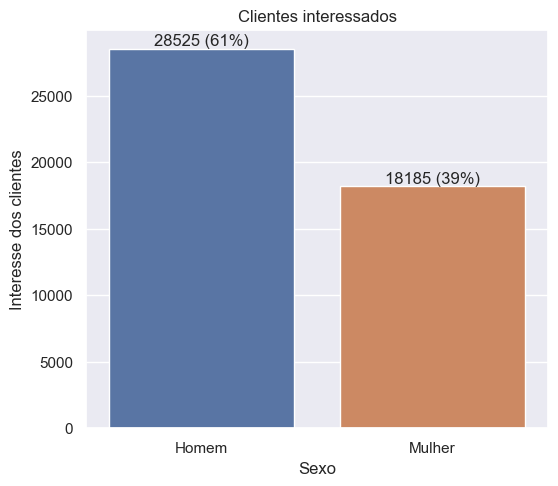

In [260]:
# Gender Interest Dashboard
#percentage of customers per gender
plt.figure(figsize=(12,6))

#interested customers per gender
bar_gen = plt.subplot (1,2,2)

# labels
gen_true = df3.loc[df3['response'] == True]
gen_res = sns.countplot(x=gen_true['gender'],
                   order=gen_true['gender'].value_counts(ascending=False).index);
abs_values = gen_true['gender'].value_counts(ascending=False)    
rel_values = gen_true['gender'].value_counts(ascending=False, normalize=True).values * 100

lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
gen_res.bar_label(container=gen_res.containers[0], labels=lbls);

bar_gen.set_title('Clientes interessados')
bar_gen.set_xlabel('Sexo')
bar_gen.set_ylabel('Interesse dos clientes')
plt.xticks([0,1],['Homem','Mulher'])
plt.tight_layout(pad=4)

#### H2: The greater the age, the greater the possibility of taking out auto insurance.

##### The hypothesis is false.

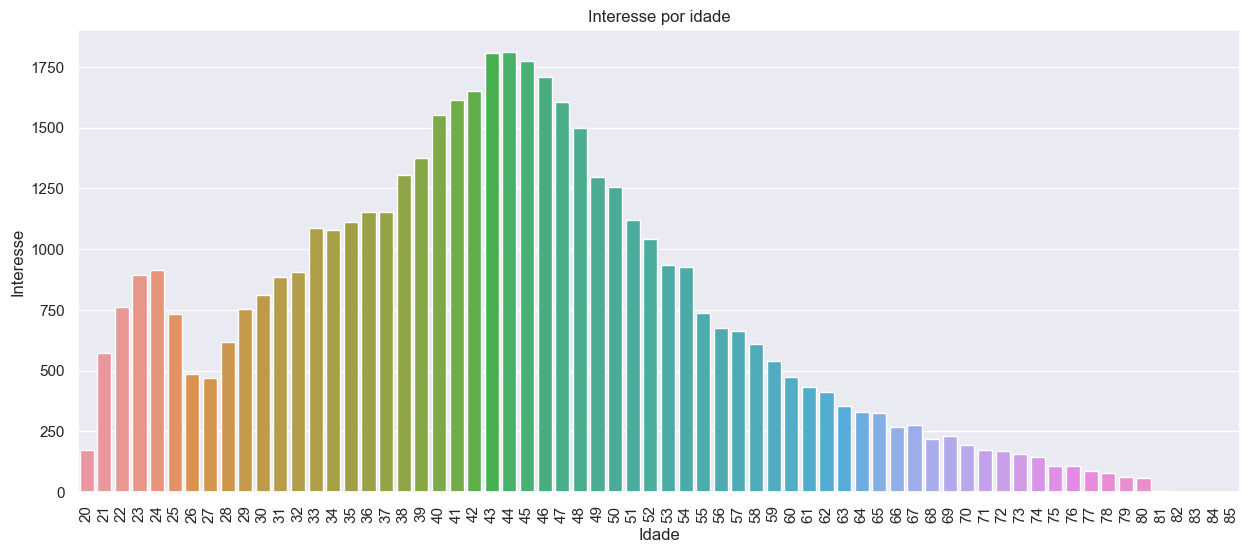

In [261]:
# Analyse just interested customers by age
plt.figure(figsize=(15,6))
aux_age2 = df3[['age', 'response']].groupby('age').sum().reset_index()
eda_age2 = sns.barplot( x='age', y='response', data=aux_age2 )
eda_age2.set_title('Interesse por idade')
eda_age2.set_xlabel('Idade')
eda_age2.set_ylabel('Interesse')
plt.xticks( rotation=90 );

#### H3: Residence influences the decision to take out auto insurance.

##### The hypothesis is TRUE. Some regions have a higher concentration of auto insurance interests.

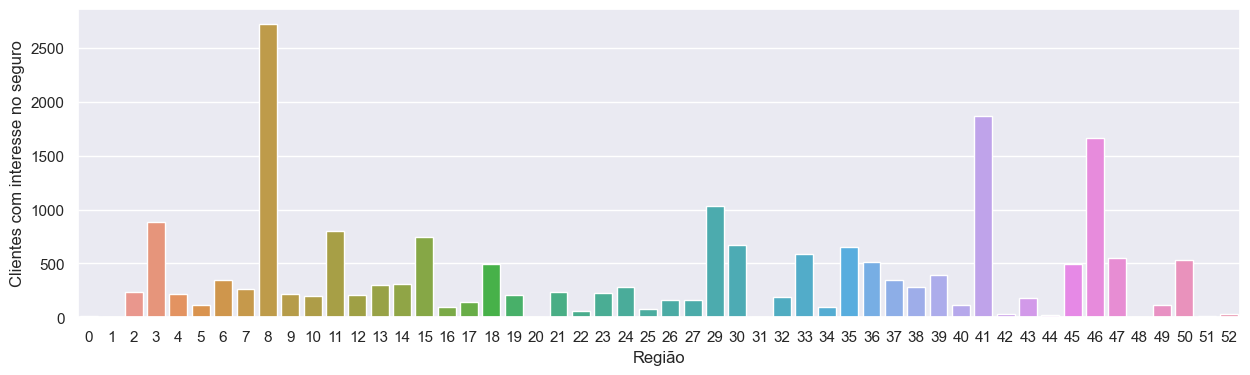

In [262]:
aux = df4[(df4['region_code'] != 28) & (df4['response'] == 1)]
fig3 = plt.subplots(figsize = (15,4))
sns.countplot(x = 'region_code', data = aux);
plt.xlabel("Região")
plt.ylabel("Clientes com interesse no seguro")
plt.show(fig3)

#### H4: People who have had damage to their car are more likely to take out car insurance.

##### The hypothesis is TRUE. When car damage occurred, there is car insurance interest.

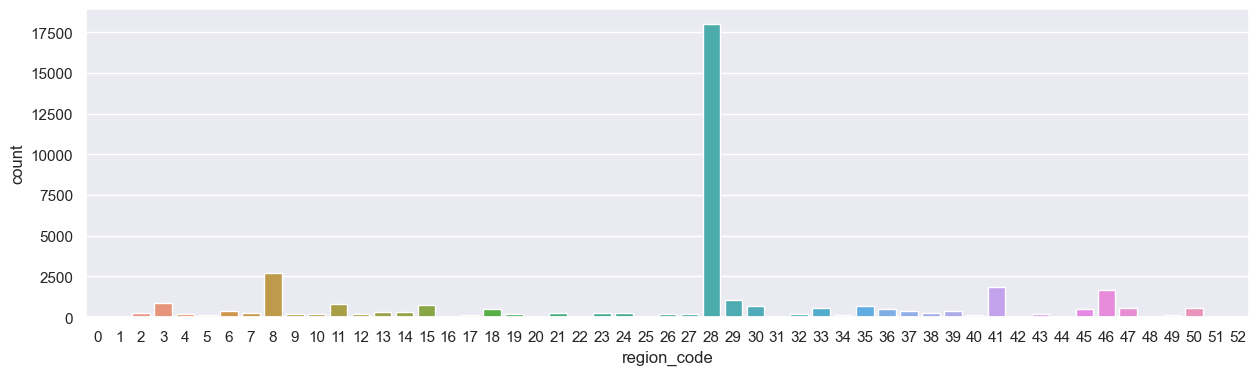

In [263]:
fig = plt.subplots(figsize = (15,4))
sns.countplot(x = 'region_code', data = df4[df4['response'] == 1]);

#### H5: Customers with higher health insurance expenses are more likely to purchase a new product.

##### The hypothesis is FALSE. There is a concentration of positive answers around of mean of annual premiums paid.

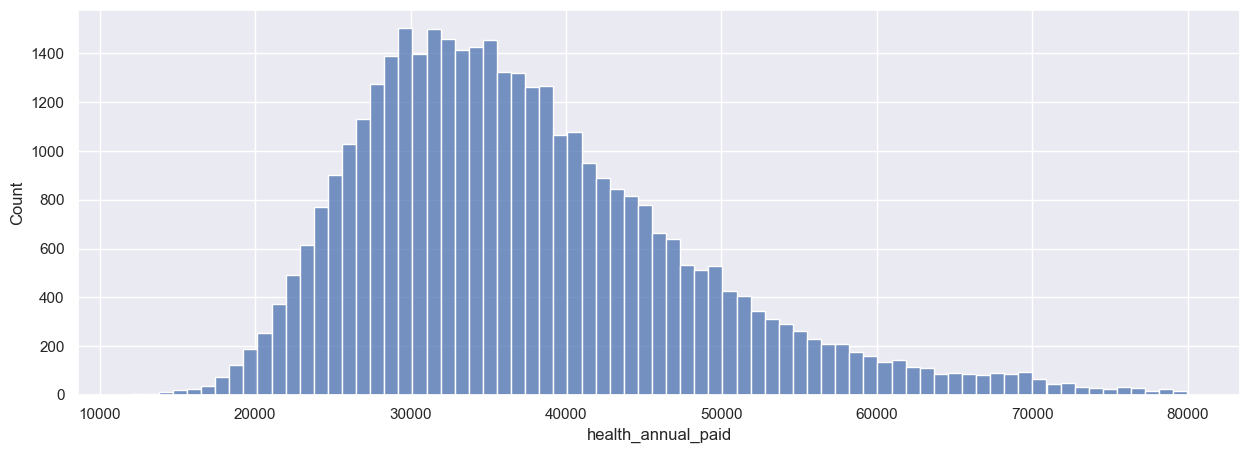

In [268]:
# health_annual_paid
h5 = df4.loc[(df4['health_annual_paid'] > 10000) & (df4['health_annual_paid'] < 80000)]
h5 = h5.loc[h5['response'] == 1, 'health_annual_paid']

fig = plt.subplots(figsize = (15,5))
sns.histplot(h5, bins = 75);

### 4.2.1 Hyphotesis resume

In [270]:
tab =[['Hyphotesis', 'Result'],
      ['H1',         'False'],
      ['H2',         'False'],
      ['H3',         'True'],
      ['H4',         'True'],
      ['H5',         'False']]

print(tabulate(tab, headers='firstrow'))

Hyphotesis    Result
------------  --------
H1            False
H2            False
H3            True
H4            True
H5            False


# 5.0. Data Preparation

In [55]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

In [56]:
df5.shape

(252359, 12)

In [57]:
# Train
x_train.to_csv('data/x_train.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)


## 5.1. Standardization

In [58]:
ss = pp.StandardScaler()

# anual premium - StandarScaler
df5['health_annual_paid'] = ss.fit_transform( df5[['health_annual_paid']].values )
#pickle.dump( ss, open( 'features/annual_premium_scaler.pkl', 'wb' ) )

## 5.2. Rescaling

In [59]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age - MinMaxScaler
df5['age'] = mms_age.fit_transform( df5[['age']].values )
#pickle.dump( mms_age, open( 'features/age_scaler.pkl', 'wb' ) )

# Vintage - MinMaxScaler
df5['days_associated'] = mms_vintage.fit_transform( df5[['days_associated']].values )
#pickle.dump( mms_vintage, open( 'features/vintage_scaler.pkl', 'wb' ) )

## 5.3. Transformation

### 5.3.1. Encoding

In [60]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
15121,15122,Male,0.400000,14,26,0,between_1_2_year,1,0,0.334665,0.546713,0
144843,144844,Male,0.092308,50,152,1,below_1_year,0,1,-0.893151,0.276817,0
194260,194261,Female,0.123077,18,152,1,below_1_year,0,1,-0.536123,0.626298,0
165985,165986,Female,0.138462,49,152,1,below_1_year,0,0,-1.217555,0.152249,0
321014,321015,Female,0.169231,46,26,1,between_1_2_year,0,1,-0.151668,0.619377,0


In [61]:
# gender - One Hot Encoding / Target Encoding
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )
#pickle.dump( target_encode_gender, open( 'features/target_encode_gender_scaler.pkl', 'wb' ) )

# region_code - Target Encoding / Frequency Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )
#pickle.dump( target_encode_region_code, open( 'features/target_encode_region_code_scaler.pkl', 'wb' ) )

# vehicle_age - One Hot Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 ) 
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )
#pickle.dump( fe_policy_sales_channel, open( 'features/fe_policy_sales_channel_scaler.pkl', 'wb' ) )

In [62]:
df5.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
15121,15122,0.138277,0.400000,0.084507,0.213795,0,1,0,0.334665,0.546713,0,0,1,0
144843,144844,0.138277,0.092308,0.057866,0.386616,1,0,1,-0.893151,0.276817,0,1,0,0
194260,194261,0.100021,0.123077,0.118049,0.386616,1,0,1,-0.536123,0.626298,0,1,0,0
165985,165986,0.100021,0.138462,0.078053,0.386616,1,0,0,-1.217555,0.152249,0,1,0,0
321014,321015,0.100021,0.169231,0.095635,0.213795,1,0,1,-0.151668,0.619377,0,0,1,0


## 5.4. Validation Preparation

In [63]:
# gender
x_validation.loc[:, 'gender'] =  x_validation.loc[:, 'gender'].map( target_encode_gender )

# age
x_validation.loc[:, 'age'] = mms_age.transform( x_validation[['age']].values )

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle_age
x_validation = pd.get_dummies( x_validation, prefix='vehicle_age', columns=['vehicle_age'] )

# annual_premium
x_validation.loc[:, 'health_annual_paid'] = ss.transform( x_validation[['health_annual_paid']].values )

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_validation.loc[:, 'days_associated'] = mms_vintage.transform( x_validation[['days_associated']].values )

# fillna
x_validation = x_validation.fillna( 0 )

In [64]:
df5

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
15121,15122,0.138277,0.400000,0.084507,0.213795,0,1,0,0.334665,0.546713,0,0,1,0
144843,144844,0.138277,0.092308,0.057866,0.386616,1,0,1,-0.893151,0.276817,0,1,0,0
194260,194261,0.100021,0.123077,0.118049,0.386616,1,0,1,-0.536123,0.626298,0,1,0,0
165985,165986,0.100021,0.138462,0.078053,0.386616,1,0,0,-1.217555,0.152249,0,1,0,0
321014,321015,0.100021,0.169231,0.095635,0.213795,1,0,1,-0.151668,0.619377,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91819,91820,0.100021,0.123077,0.076572,0.213795,1,0,0,-0.022362,0.622837,0,1,0,0
322305,322306,0.138277,0.092308,0.187155,0.386616,1,0,1,-0.225844,0.318339,0,1,0,0
65755,65756,0.100021,0.015385,0.095635,0.386616,1,1,0,-0.919668,0.896194,0,1,0,0
117851,117852,0.100021,0.076923,0.102651,0.386616,1,0,1,-0.712177,0.380623,0,1,0,0


# 6.0. Feature Selection

In [65]:
df6 = df5.copy()

## 6.1 Split Dataframe

In [66]:
# data preparation
x_train_n = df6.drop(['id', 'response'], axis=1).values
y_train_n = y_train.values.ravel()

## 6.2. Feature Importance

In [67]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0            health_annual_paid    0.273134
0               days_associated    0.247360
0                           age    0.156744
0                   region_code    0.104365
0                vehicle_damage    0.070069
0          vehicle_prev_insured    0.059796
0          policy_sales_channel    0.056884
0      vehicle_age_below_1_year    0.016463
0  vehicle_age_between_1_2_year    0.006868
0                        gender    0.005084
0      vehicle_age_over_2_years    0.002695
0               driving_license    0.000536


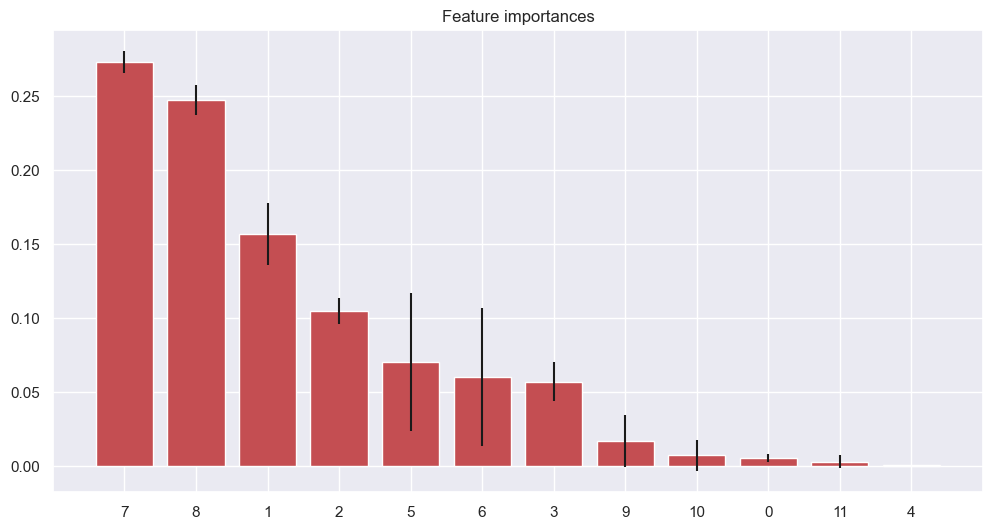

In [68]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. Machine Learning Modelling

### Dado o problema de negócio, o objetivo do projeto é construir uma lista ordenada de propensão de compra. Assim: 
**1.** Construímos alguns modelos, seus desempenhos foram comparados e analisamos qual deles fez melhor a tarefa de classificação.<br>
**2.** Realizamos uma análise mais detalhada com cada modelo, por meio de validação cruzada e ajuste de hiperparâmetros.<br>

In [69]:
df7 = df6.copy()

In [70]:
df7.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
15121,15122,0.138277,0.400000,0.084507,0.213795,0,1,0,0.334665,0.546713,0,0,1,0
144843,144844,0.138277,0.092308,0.057866,0.386616,1,0,1,-0.893151,0.276817,0,1,0,0
194260,194261,0.100021,0.123077,0.118049,0.386616,1,0,1,-0.536123,0.626298,0,1,0,0
165985,165986,0.100021,0.138462,0.078053,0.386616,1,0,0,-1.217555,0.152249,0,1,0,0
321014,321015,0.100021,0.169231,0.095635,0.213795,1,0,1,-0.151668,0.619377,0,0,1,0


In [71]:
cols_selected = ['health_annual_paid', 'days_associated', 'age', 'region_code', 'vehicle_damage', 'vehicle_prev_insured',
                 'policy_sales_channel']

In [72]:
x_train = df5[ cols_selected ]

x_val = x_validation[ cols_selected ]
y_val = y_validation

## 7.1. KNN Classifier

In [73]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

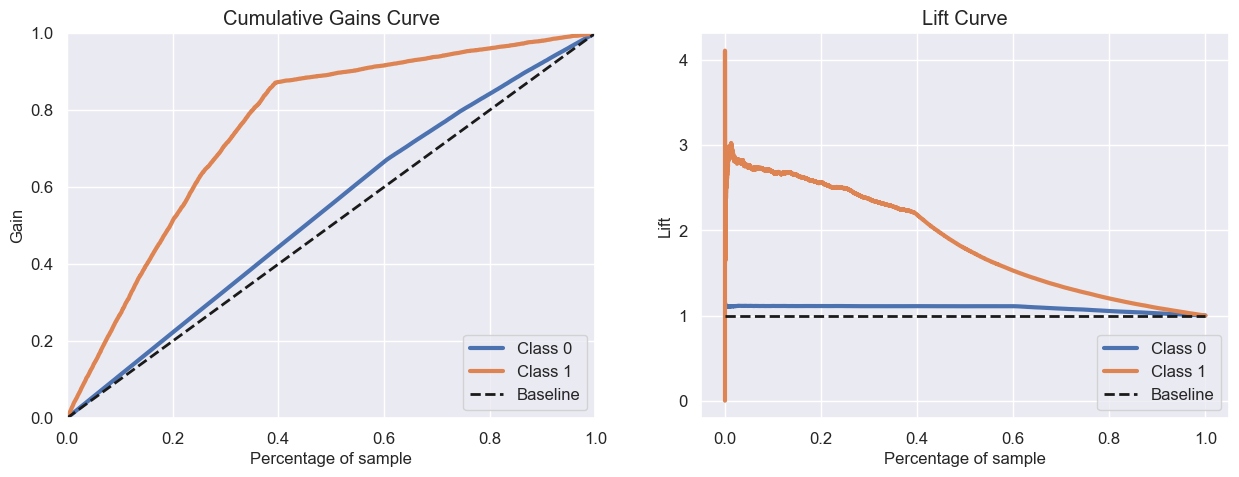

In [74]:
# Accumulative Gain
fig, axs = plt.subplots(ncols = 2, figsize = (15, 5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax = axs[0])

# Lift
skplt.metrics.plot_lift_curve(y_val, yhat_knn, ax = axs[1]);

In [75]:
# Performance
# compute precision at k
knn_precision_at_k = round(precision_at_k(df7, x_validation, y_validation, yhat_knn, 25000), 3)
print('KNN Model - Precision at K: {}'.format(knn_precision_at_k))

# compute Recall at k
knn_recall_at_k = round(recall_at_k(df7, x_validation, y_validation, yhat_knn, 25000), 3)
print('KNN Model - Recall at K: {}'.format(knn_recall_at_k))

KNN Model - Precision at K: 0.268
KNN Model - Recall at K: 0.872


### KNN - Cross Validation

In [76]:
knn_cv  = cross_validation (df7, 5, 'KNN CV', knn_model, x_train, y_train, 20000)

In [77]:
knn_cv

{'Model Name': 'KNN CV',
 'Precision_at_k': '0.265 +/- 0.001',
 'Recall_at_k': '0.872 +/- 0.003'}

In [78]:
rp_knn_cv = pd.DataFrame.from_dict(knn_cv, orient='index').T

In [79]:
rp_knn_cv

,Model Name,Precision_at_k,Recall_at_k
0,KNN CV,0.265 +/- 0.001,0.872 +/- 0.003


## 7.2. Logistic Regression

In [80]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

In [81]:
yhat_lr

array([[7.62560161e-01, 2.37439839e-01],
       [9.99202224e-01, 7.97776008e-04],
       [7.00427887e-01, 2.99572113e-01],
       ...,
       [9.91212633e-01, 8.78736692e-03],
       [6.83290496e-01, 3.16709504e-01],
       [9.99350039e-01, 6.49960829e-04]])

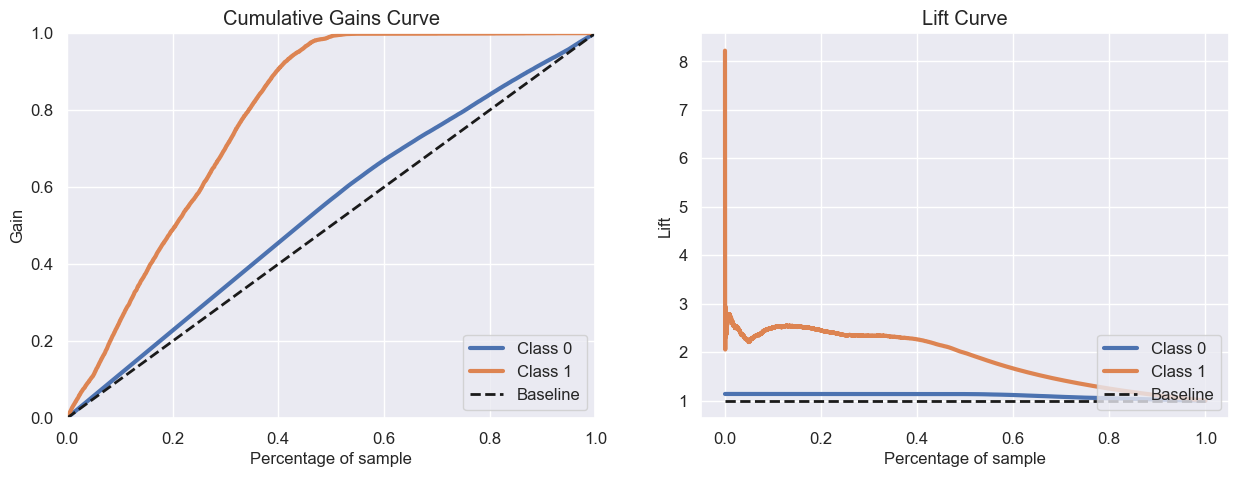

In [82]:
# Accumulative Gain
fig, axs = plt.subplots(ncols = 2, figsize = (15, 5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax = axs[0])

# Left
skplt.metrics.plot_lift_curve(y_val, yhat_lr, ax = axs[1]);

In [83]:
# Performance
# compute precision at k
lr_precision_at_k = round(precision_at_k(df7, x_validation, y_validation, yhat_lr, 25000), 3)
print('LRegression Model - Precision at K: {}'.format(lr_precision_at_k))

# compute Recall at k
lr_recall_at_k = round(recall_at_k(df7, x_validation, y_validation, yhat_lr, 25000), 3)
print('LRegression Model - Recall at K: {}'.format(lr_recall_at_k))

LRegression Model - Precision at K: 0.276
LRegression Model - Recall at K: 0.9


### 7.2.1 Logistic Regression - Cross Validation

In [84]:
lr_cv  = cross_validation (df7, 5, 'LRegression CV', lr_model, x_train, y_train, 20000)

In [85]:
lr_cv

{'Model Name': 'LRegression CV',
 'Precision_at_k': '0.274 +/- 0.002',
 'Recall_at_k': '0.903 +/- 0.005'}

In [86]:
rp_lr_cv = pd.DataFrame.from_dict(lr_cv, orient='index').T

In [87]:
rp_lr_cv

,Model Name,Precision_at_k,Recall_at_k
0,LRegression CV,0.274 +/- 0.002,0.903 +/- 0.005


## 7.3 Extra Trees Classifier

In [88]:
# model definition
et = en.ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=14)

# model training
et.fit(x_train, y_train)

# model prediction
yhat_et = et.predict_proba(x_val)

In [89]:
yhat_et

array([[0.6 , 0.4 ],
       [1.  , 0.  ],
       [0.66, 0.34],
       ...,
       [0.94, 0.06],
       [0.86, 0.14],
       [1.  , 0.  ]])

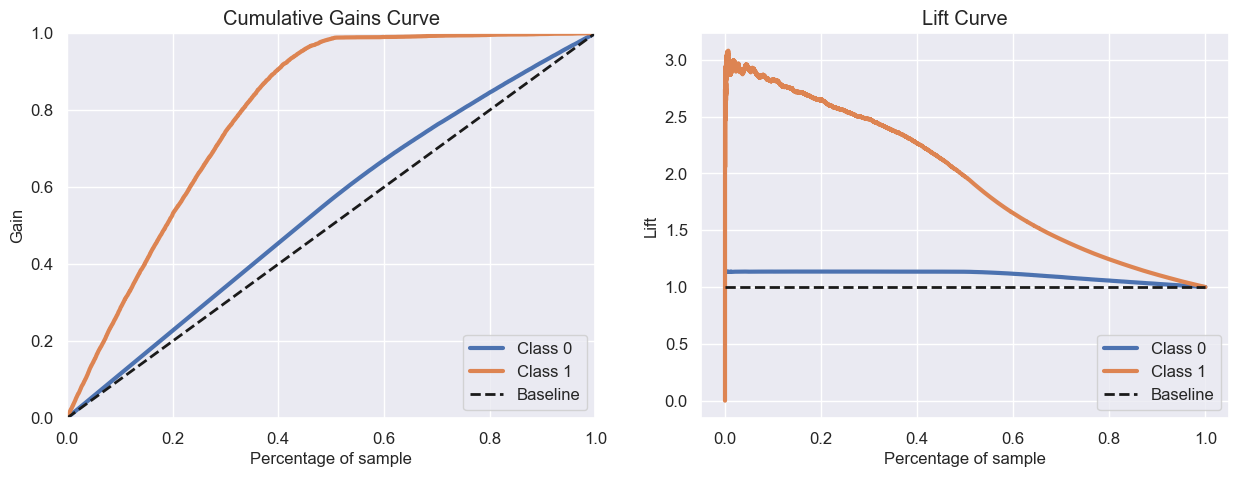

In [90]:
# Accumulative Gain
fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_et, ax = axs[0]);

# Left
skplt.metrics.plot_lift_curve(y_val, yhat_et, ax = axs[1]);

In [91]:
# Performance

# compute precision at k
et_precision_at_k = round(precision_at_k(df7, x_validation, y_validation, yhat_et, 25000), 3)
print('ETrees Model - Precision at K: {}'.format(et_precision_at_k))

# compute Recall at k
et_recall_at_k = round(recall_at_k(df7, x_validation, y_validation, yhat_et, 25000), 3)
print('ETrees Model - Recall at K: {}'.format(et_recall_at_k))

ETrees Model - Precision at K: 0.277
ETrees Model - Recall at K: 0.902


### 7.3.1 Extra Tress - Cross Validation

In [92]:
et_cv  = cross_validation (df7, 5, 'ETrees CV', et, x_train, y_train, 20000)

In [93]:
rp_et_cv = pd.DataFrame.from_dict(et_cv, orient='index').T

## 7.4 Random Forest

In [94]:
# model definition
rf = en.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=14) 

# model training
rf.fit(x_train, y_train)

# model prediction
yhat_rf = et.predict_proba(x_val)

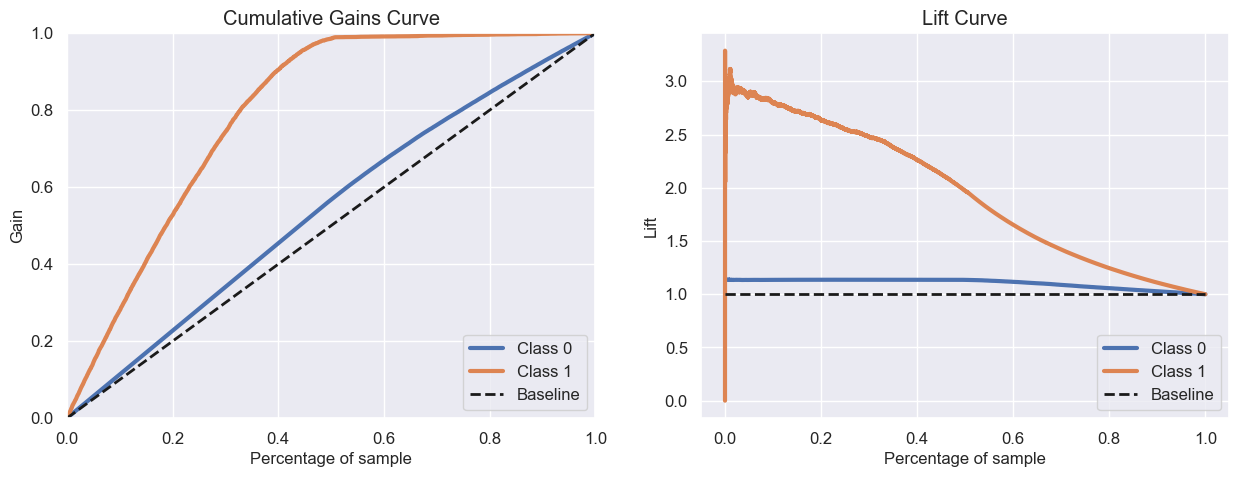

In [95]:
# Accumulative Gain
fig, axs = plt.subplots(ncols= 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf, ax = axs[0])

# Left
skplt.metrics.plot_lift_curve(y_val, yhat_rf, ax = axs[1]);

In [96]:
# Performance

# compute precision at k
rfc_precision_at_k = round(precision_at_k(df7, x_validation, y_validation, yhat_rf, 25000), 3)
print('RFC Model - Precision at K: {}'.format(rfc_precision_at_k))

# compute Recall at k
rfc_recall_at_k = round(recall_at_k(df7, x_validation, y_validation, yhat_rf, 25000), 3)
print('RFC Model - Recall at K: {}'.format(rfc_recall_at_k))

RFC Model - Precision at K: 0.276
RFC Model - Recall at K: 0.9


### 7.4.1 Random Forest - Cross Validation

In [97]:
rfc_cv  = cross_validation (df7, 5, 'RForest CV', rf, x_train, y_train, 20000)

In [98]:
rp_rfc_cv = pd.DataFrame.from_dict(rfc_cv, orient='index').T

## 7.5 XGBoost Classifier

In [99]:
xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'error')

xgb_model.fit(x_train,y_train)

yhat_xgb = xgb_model.predict_proba(x_val)

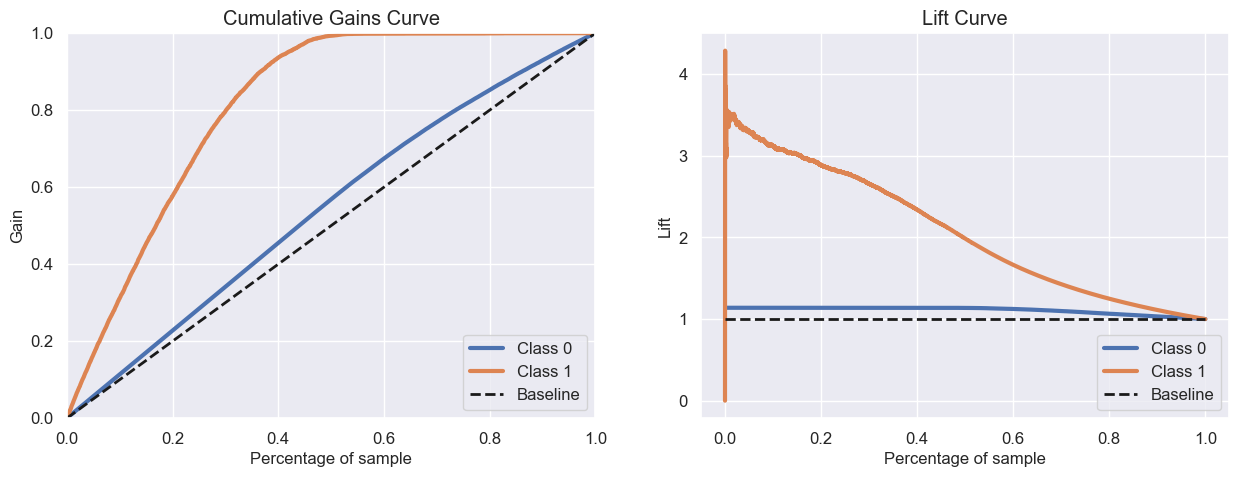

In [100]:
fig, axs = plt.subplots(ncols = 2, figsize = (15, 5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, ax = axs[0])

# Left
skplt.metrics.plot_lift_curve(y_val, yhat_xgb, ax = axs[1]);

In [101]:
# Performance

# compute precision at k
xgb_precision_at_k = round(precision_at_k(df7, x_validation, y_validation, yhat_xgb, 25000), 3)
print('RFC Model - Precision at K: {}'.format(xgb_precision_at_k))

# compute Recall at k
xgb_recall_at_k = round(recall_at_k(df7, x_validation, y_validation, yhat_xgb, 25000), 3)
print('RFC Model - Recall at K: {}'.format(xgb_recall_at_k))

RFC Model - Precision at K: 0.286
RFC Model - Recall at K: 0.932


### 7.5.1 XGBoost - Cross Validation

In [102]:
xgb_cv  = cross_validation (df7, 5, 'XGB CV', xgb_model, x_train, y_train, 20000)

In [103]:
rp_xgb_cv = pd.DataFrame.from_dict(xgb_cv, orient='index').T

## 7.6 Compare model's Performance

### 7.6.1 Single Performance

In [104]:
m_perf_dict = {
'Model Name'      : ['KNN', 'LRegression', 'Etrees', 'RForest', 'XGB'],
'Precision_at_k': [knn_precision_at_k, lr_precision_at_k, et_precision_at_k, rfc_precision_at_k, xgb_precision_at_k],
'Recall_at_k': [knn_recall_at_k, lr_recall_at_k, et_recall_at_k, rfc_recall_at_k, xgb_recall_at_k]}

m_performance_sp = pd.DataFrame(m_perf_dict).sort_values('Recall_at_k', ascending = False).reset_index(drop = True)
m_performance_sp

,Model Name,Precision_at_k,Recall_at_k
0,XGB,0.286,0.932
1,Etrees,0.277,0.902
2,LRegression,0.276,0.900
3,RForest,0.276,0.900
4,KNN,0.268,0.872


### 7.6.2 Real Performance - Cross Validation

In [105]:
models_performance_cv = pd.concat([rp_knn_cv, rp_lr_cv, rp_et_cv, rp_rfc_cv, rp_xgb_cv]).sort_values('Recall_at_k', ascending = False).reset_index(drop = True)
models_performance_cv

,Model Name,Precision_at_k,Recall_at_k
0,XGB CV,0.284 +/- 0.001,0.935 +/- 0.004
1,RForest CV,0.277 +/- 0.001,0.911 +/- 0.003
2,ETrees CV,0.275 +/- 0.0,0.904 +/- 0.001
3,LRegression CV,0.274 +/- 0.002,0.903 +/- 0.005
4,KNN CV,0.265 +/- 0.001,0.872 +/- 0.003


# 8.0 Hyperparameter fine tuning

In [106]:
df8 = df7.copy()

## 8.1 Random Search

In [107]:
param = { 'objective'        : ['binary:logistic'],
          'eval_metric'      : ['error'],
          'n_estimators'     : [500, 750, 1000], 
          'eta'              : [0.01, 0.05, 0.09],
          'max_depth'        : [1, 5, 9],
          'subsample'        : [0.1, 0.5, 0.9],
          'colsample_bytree' : [0.1, 0.5, 0.9],
          'min_child_weight' : [3, 12, 20] 
        }

MAX_EVAL = 10

In [108]:
final_result = pd.DataFrame({'Model Name':[], 'Precision_at_k': [], 'Recall_at_k': []})

In [109]:
final_result

,Model Name,Precision_at_k,Recall_at_k


In [110]:
# for i in range (MAX_EVAL):
#    hp = {w: random.sample(v, 1) [0] for w, v in param.items()}
#    print ('Step ' + str(i + 1) + '/' + str(MAX_EVAL))
#    print (hp)
     
#model_xgb = xgb.XGBClassifier(
#                 objective = hp['objective'],
#                 eval_metric = hp['eval_metric'],
#                 n_estimators = hp['n_estimators'], 
#                 eta = hp['eta'], 
#                 max_depth = hp['max_depth'], 
#                 subsample = hp['subsample'],
#                 colsample_bytree = hp['colsample_bytree'],
#                 min_child_weight = hp['min_child_weight'])
     
#result = cross_validation (df8, 5, 'XGBoost FT', model_xgb, x_train, y_train, 20000)
#result = pd.DataFrame.from_dict(result, orient='index').T
#final_result = pd.concat([final_result, result])
     
# final_result = pd.DataFrame(final_result)

In [111]:
# final_result.reset_index(drop = True)

In [112]:
# final_res = final_result.sort_values('Recall_at_k', ascending = False)
# final_res 

## 8.2 Final Model

In [113]:
xgb_param_tuned = {'objective': 'binary:logistic', 
                   'eval_metric': 'error', 
                   'n_estimators': 750, 
                   'eta': 0.05, 
                   'max_depth': 5, 
                   'subsample': 0.5, 
                   'colsample_bytree': 0.9, 
                   'min_child_weight': 20
                  }

In [114]:
model_xgb_tuned = xgb.XGBClassifier (
    objective = xgb_param_tuned['objective'],
    eval_metric = xgb_param_tuned['eval_metric'],
    n_estimators = xgb_param_tuned['n_estimators'], 
    eta = xgb_param_tuned['eta'], 
    max_depth = xgb_param_tuned['max_depth'], 
    subsample = xgb_param_tuned['subsample'],
    colsample_bytree = xgb_param_tuned['colsample_bytree'],
    min_child_weight = xgb_param_tuned['min_child_weight'])

model_xgb_tuned.fit(x_train, y_train)

yhat_xgb_tuned = model_xgb_tuned.predict_proba(x_val)

In [173]:
yhat_xgb_tuned.shape

(63090, 2)

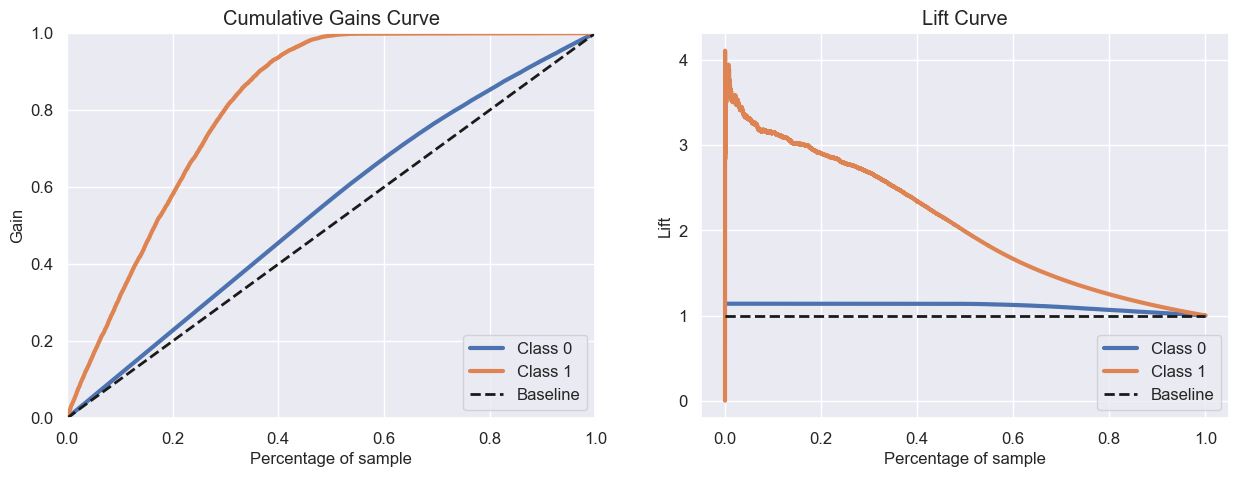

In [115]:
# Accumulative Gain
fig, axs = plt.subplots(ncols = 2, figsize = (15,5))
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb_tuned, ax = axs[0])
skplt.metrics.plot_lift_curve(y_val, yhat_xgb_tuned, ax = axs[1]);

In [116]:
# Compute Recall at k
xgb_recall_at_20000 = round(recall_at_k(df8, x_validation, y_validation, yhat_xgb, 20000), 3)
print('XGB Model - Recall at K: {}'.format(xgb_recall_at_k))

XGB Model - Recall at K: 0.932


# 9.0 Error Interpretation

## 9.1 Machine Learning - Test Dataset

In [148]:
# Test Dataset Extraction
X = df1.drop('response', axis = 1).copy()
y = df1['response'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 45)

# df_test is a separate dataset, and will be used to perfomr the final evaluation of the trained model
df_test = pd.concat([x_test, y_test], axis = 1)

In [149]:
df_test

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
275163,275164,Female,24,41,152,1,< 1 Year,No,1,31696.0,62,0
228955,228956,Female,39,41,124,1,1-2 Year,Yes,0,34202.0,188,0
183986,183987,Female,25,39,152,1,< 1 Year,No,0,31140.0,200,0
272782,272783,Female,67,28,26,1,> 2 Years,Yes,0,2630.0,17,0
24900,24901,Male,23,46,152,1,< 1 Year,No,1,32159.0,149,0
...,...,...,...,...,...,...,...,...,...,...,...,...
327865,327866,Male,27,33,152,1,< 1 Year,No,1,32955.0,23,0
18930,18931,Male,49,40,124,1,> 2 Years,Yes,0,2630.0,277,0
135229,135230,Male,24,27,152,1,< 1 Year,No,0,26595.0,277,0
105049,105050,Male,22,29,152,1,< 1 Year,No,1,42844.0,140,0


In [174]:
print('Check NA:')
x_test.isna().sum()

Check NA:


id                               0
gender                           0
age                              0
region_code                      0
policy_sales_channel            27
driving_license                  0
vehicle_damage                   0
vehicle_prev_insured             0
health_annual_paid               0
days_associated                  0
vehicle_age_below_1_year         0
vehicle_age_between_1_2_year     0
vehicle_age_over_2_years         0
dtype: int64

In [175]:
# Check the rows with NaN
x_test.loc[x_test['policy_sales_channel'].isna()]

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years
291039,291040,0.100021,35.0,0.375000,NaN,1,0,1,2630.0,0.622837,0,1,0
359067,359068,0.138277,44.0,0.333333,NaN,1,0,1,2630.0,0.951557,0,1,0
250008,250009,0.100021,59.0,0.333333,NaN,1,0,1,2630.0,0.384083,0,1,0
237606,237607,0.138277,72.0,0.375000,NaN,1,0,1,2630.0,0.685121,0,1,0
125340,125341,0.100021,48.0,0.375000,NaN,1,1,0,2630.0,0.332180,0,0,1
155079,155080,0.138277,54.0,0.250000,NaN,1,1,0,2630.0,0.667820,0,1,0
263727,263728,0.100021,56.0,0.250000,NaN,1,1,0,2630.0,0.667820,0,1,0
222111,222112,0.138277,48.0,0.375000,NaN,1,0,1,2630.0,0.411765,0,1,0
354340,354341,0.100021,77.0,0.375000,NaN,1,0,1,2630.0,0.608997,0,1,0
67447,67448,0.138277,65.0,0.375000,NaN,1,1,0,2630.0,0.695502,0,1,0


### Test preparation
- Here, the same steps performed on the train data must be performed on the test data.

In [252]:
#load x_test and y_test from test data.
#x_test = pd.read_csv(datapath+'full_test_data.csv.csv', index_col=0)
x_test = df_test
y_test = x_test['response']
x_test = x_test.drop('response', axis=1)
x_test

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated
275163,275164,Female,24.0,41,152,1,below_1_year,0,1,31696.0,0.179931
228955,228956,Female,39.0,41,124,1,between_1_2_year,1,0,34202.0,0.615917
183986,183987,Female,25.0,39,152,1,below_1_year,0,0,31140.0,0.657439
272782,272783,Female,67.0,28,26,1,over_2_years,1,0,2630.0,0.024221
24900,24901,Male,23.0,46,152,1,below_1_year,0,1,32159.0,0.480969
...,...,...,...,...,...,...,...,...,...,...,...
327865,327866,Male,27.0,33,152,1,below_1_year,0,1,32955.0,0.044983
18930,18931,Male,49.0,40,124,1,over_2_years,1,0,2630.0,0.923875
135229,135230,Male,24.0,27,152,1,below_1_year,0,0,26595.0,0.923875
105049,105050,Male,22.0,29,152,1,below_1_year,0,1,42844.0,0.449827


In [253]:
# ----- Feature Engeneering ----- 
# Vehicle Damage Number
x_test['vehicle_damage'] = x_test['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

# Vehicle Age
x_test['vehicle_age'] =  x_test['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year' )

# ----- Data Preparation - Standardization ----- 
#health_annual_paid: StandardScaler
x_test['health_annual_paid'] = ss.transform(x_test[['health_annual_paid']].values)
    #If we used fit_transform() on our test data too, we would compute a new mean and variance, that is a new scale for each feature, and would let our model learn about our test data too. Using transform() we use the same mean and variance as it is calculated from our training data to transform our test data.

# ----- Data Preparation - Rescaling ----- 
#age: MinMaxScaler
x_test['age'] = mms_age.transform( x_test[['age']].values )
#days_associated: MinMaxScaler
x_test['days_associated'] = mms_vintage.fit_transform( x_test[['days_associated']].values )


# ----- Data Preparation - Encoding ----- 
#vehicle_age: one hot encoding 
x_test = pd.get_dummies( x_test, prefix='vehicle_age', columns=['vehicle_age'] ) 
#gender: target encoding
x_test.loc[:,'gender'] = x_test.loc[:,'gender'].map(target_encode_gender)
#region_code: target encoding
x_test.loc[:,'region_code'] = x_test.loc[:,'region_code'].map(target_encode_region_code)
#policy_sales_channel: frequency encoding
x_test.loc[:,'policy_sales_channel'] = x_test['policy_sales_channel'].map(fe_policy_sales_channel)

In [256]:
x_test.shape

(76222, 11)

## 9.2 Business Performance

In [208]:
# rounding the number of calls to 40000 to Compute Recall at k based on the validation dataset and previous yhat_xgb
xgb_recall_at_k = round(recall_at_k(df8, x_validation, y_validation, yhat_xgb, 40000), 3)
print('XGB Model - Recall at K: {}'.format(xgb_recall_at_k))
print('Percentage of customers interested: {}%'.format(xgb_recall_at_k*100))

XGB Model - Recall at K: 0.999
Percentage of customers interested: 99.9%


### 9.2.2 Percentage of clients interested in vehicle insurance that will be contacted with 20.000 calls.

In [197]:
data = x_test.copy()
data['target'] = y_test.copy()
data.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,target
275163,275164,0.100021,24.0,0.114841,0.386616,1,0,1,31696.0,0.179931,0,1,0,0,0
228955,228956,0.100021,39.0,0.114841,0.195472,1,1,0,34202.0,0.615917,0,0,1,0,0
183986,183987,0.100021,25.0,0.106588,0.386616,1,0,0,31140.0,0.657439,0,1,0,0,0
272782,272783,0.100021,67.0,0.187155,0.213795,1,1,0,2630.0,0.024221,0,0,0,1,0
24900,24901,0.138277,23.0,0.095635,0.386616,1,0,1,32159.0,0.480969,0,1,0,0,0


In [241]:
# getting the percentage provided by the algorithm based on test dataset
calls = 20000
total_leads = data.shape[0]

percent_at_20k = 20000 / len(data)
recall_at_20k, table_20k = precision_recall_at_k(data, k=20000)

perc_calls = calls / total_leads
print('Total leads: {}'.format(total_leads))
print('% of calls: {0:.2f}%'.format(perc_calls*100))

Total leads: 76222
% of calls: 26.24%


In [200]:
round(20000 / data.shape[0]*100 )

26

In [201]:
round(data.loc[data['target'] == 1].shape[0])

9342

In [205]:
round(data['health_annual_paid'].median())

31666

## Results: 
- We have 76222 new customers, of which 9342 are interested in vehicle insurance. (12.24% of total new customers)
- The average ticket for an annual health insurance from Insurance All is: $31669.

### 9.2.3 And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing vehicle insurance will the sales team be able to contact?

In [210]:
# getting the percentage provided by the algorithm based on test dataset
calls = 40000
total_leads = data.shape[0]
perc_calls = calls / total_leads
print('Total leads: {}'.format(total_leads))
print('% of calls: {0:.2f}%'.format(perc_calls*100))

Total leads: 76222
% of calls: 52.48%


## Results: 
  - The sales team contacts 52,48% of those interested in car insurance: 4902 customers.
- Estimated revenue = 4902 * 31669 = $155.24M per year.

In [ ]:
results = pd.DataFrame()
results['prediction'] = yhat_xgb[:,1].tolist()

# Compute bucket
results['bucket'] = results['prediction'].apply(lambda x: 
                                                
                0.9 if x >= 0.90 else                               
                0.8 if (x >= 0.80) & (x < 0.90) else                        
                0.7 if (x >= 0.70) & (x < 0.80) else                                 
                0.6 if (x >= 0.60) & (x < 0.70) else                              
                0.5 if (x >= 0.50) & (x < 0.60) else                                
                0.4 if (x >= 0.40) & (x < 0.50) else                                
                0.3 if (x >= 0.30) & (x < 0.40) else                                
                0.2 if (x >= 0.20) & (x < 0.30) else                                 
                0.1 if (x >= 0.10) & (x < 0.20) else 0.01)

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby('bucket').agg({'min', 'count'}).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']
df['base'] = df['clients'].sort_values(ascending=True).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values('index', ascending=False)
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
7,0.70,0.700502,10,280.200768,2.802008,1.000000,277.398760
6,0.60,0.606217,28,678.962736,2.424867,0.750426,676.537869
5,0.50,0.500020,226,4520.184817,2.000082,0.534444,4518.184736
4,0.40,0.400000,2810,44960.024118,1.600001,0.356297,44958.424118
3,0.30,0.300003,8494,101929.067242,1.200013,0.213785,101927.867230
2,0.20,0.200020,7748,61990.212359,0.800080,0.106901,61989.412279
1,0.10,0.100002,6304,25216.599693,0.400010,0.035638,25216.199684
0,0.01,0.000025,37470,37.696037,0.000101,0.000009,37.695936


## 10. Conclusion

- Based on business results, Health Insurance now has a competitive advantage over its competitors, reducing the cost of acquiring customers and increasing its revenue.
- The sales team can focus their attention on the first 20,000 or 40,000 customers on the list, and in the future, focus on the top K customers on the new list.
- Insights were revealed and with the results obtained it is possible to simulate customer profiles, functionality that is of great value to the company.

## 11. Next Steps
- Perform a principal component analysis (PCA) on the data sets.
- Test the Boruta
- Use other classification algorithms
- Deploy the model
